In [1]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
import numpy as np

In [2]:
input_train = pd.read_csv("input_train.csv")
output_train = pd.read_csv("output_train.csv")
print(input_train.shape, output_train.shape)

(8028, 2) (8028, 2)


In [3]:
input_train.count()

ID          8028
question    8028
dtype: int64

In [4]:
output_train.head()

,ID,intention
0,0,28
1,1,31
2,2,28
3,3,44
4,4,31


In [5]:
# What the data look like ?
input_train['question'][3]

"Est-ce qu'il existe une forme adaptée aux enfant de 5ans du Micropakine ?"

In [ ]:
# The dataset is pretty umbalanced
plt.plot(output_train.groupby('intention').count()['ID'])
plt.rcParams["figure.figsize"] = (20,10)
plt.show()
# output_train.groupby('intention')['ID'].count()

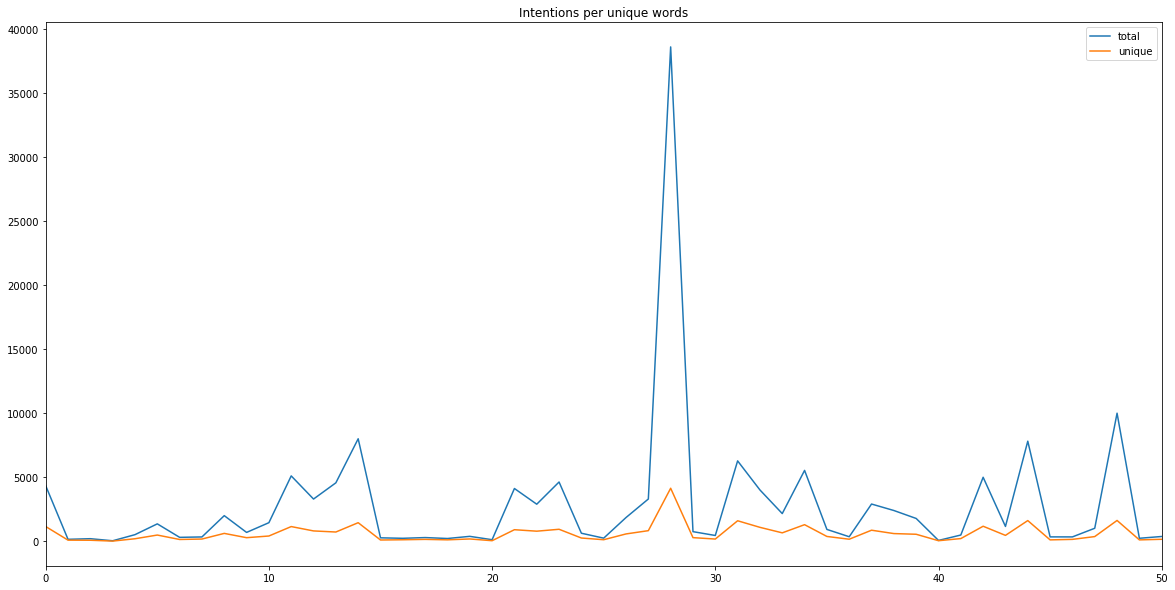

In [7]:
# Let explore the worf distribution for each class
tokenizer = nltk.RegexpTokenizer(r'\w+')
from collections import defaultdict

def freq_stats_corpora():
    corpora = defaultdict(list)

    # Corpus creation, tokenizing
    for question,intention in zip(input_train['question'],output_train['intention']):
        corpora[intention] += tokenizer.tokenize(question.lower())

    stats, freq = dict(), dict()

    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())} 
    return (freq, stats, corpora)

freq, stats, corpora = freq_stats_corpora()
df = pd.DataFrame.from_dict(stats, orient='index')

df.plot(title='Intentions per unique words')

In [8]:
# Let's compute the total frequency for each word in the corpora
freq_totale = nltk.Counter()
for k, v in corpora.items():
     freq_totale += freq[k]

# Then arbitrary remove the one hundred more common words. It might not impact the model very much but who knows
most_freq = [x[0] for x in freq_totale.most_common(100)]
print(most_freq)

# Finally adding the french stopwords
sw = set()
sw.update(most_freq)
sw.update(tuple(nltk.corpus.stopwords.words('french')))

['de', 'je', 'est', 'et', 'la', 'le', 'j', 'que', 'ai', 'ce', 'un', 'a', 'il', 'l', 'du', 'des', 'les', 'en', 'd', 'pour', 'une', 'à', 'pas', 'si', 'depuis', 'peut', 'prendre', 'ma', 'pilule', 'suis', 'mon', 'me', 'on', 'avec', 'ou', 'au', 'vous', 'qu', 'mais', 'm', 'qui', 'y', 'c', 'plus', 'effets', 'faire', 'jours', 'ne', 't', 'sous', 'mes', 'mois', 'par', 'sur', 'n', 'sont', 'fait', 'savoir', '2', 'prends', 'eu', 'dans', 'temps', 'pris', 'vaccin', 'avoir', 'grossesse', 'prise', 'règles', 'prend', 'plaquette', 'jour', 'dois', 'elle', 'combien', 'normal', 'contre', 'pendant', 'traitement', 'après', '1', 'ça', 'deroxat', 'quels', 'quel', 'enceinte', 'risque', 'secondaires', 'effet', '3', 'quand', 's', 'donc', 'pillule', 'quoi', 'comment', 'quelle', 'soir', 'comme', 'cela']


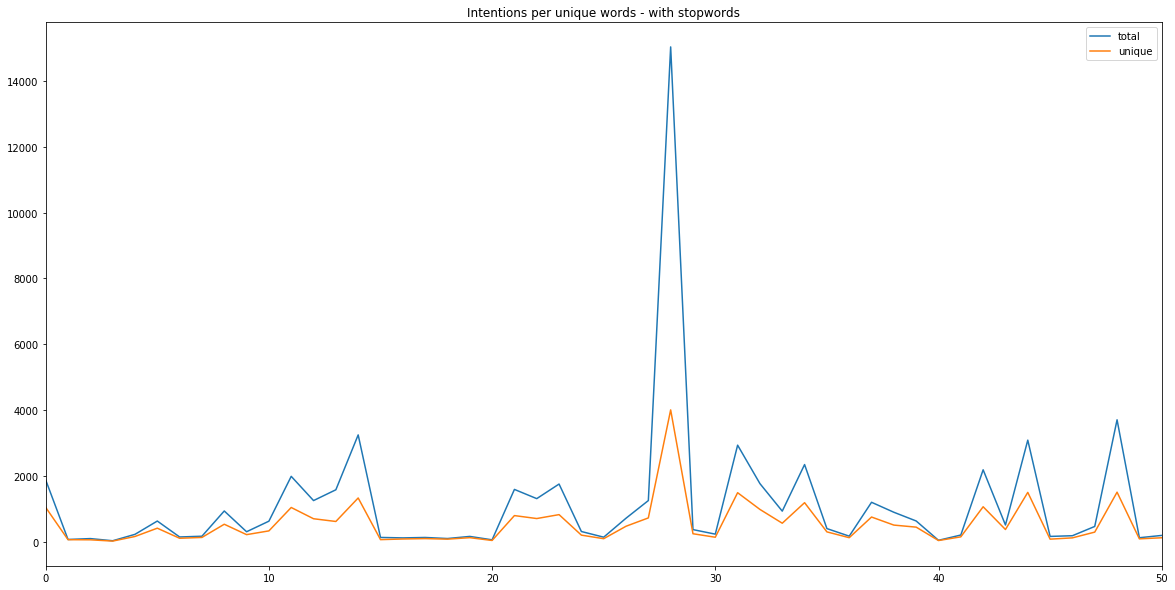

In [9]:
def freq_stats_corpora2(lookup_table=[]):
    corpora = defaultdict(list)
    
    # Corpus creation
    for question,intention in zip(input_train['question'],output_train['intention']):
        tokens = tokenizer.tokenize(question.lower())
        corpora[intention] += [w for w in tokens if not w in list(sw)]

    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}
    return (freq, stats, corpora)

freq2, stats2, corpora2 = freq_stats_corpora2()
df = pd.DataFrame.from_dict(stats2, orient='index')

df.plot(title='Intentions per unique words - with stopwords')

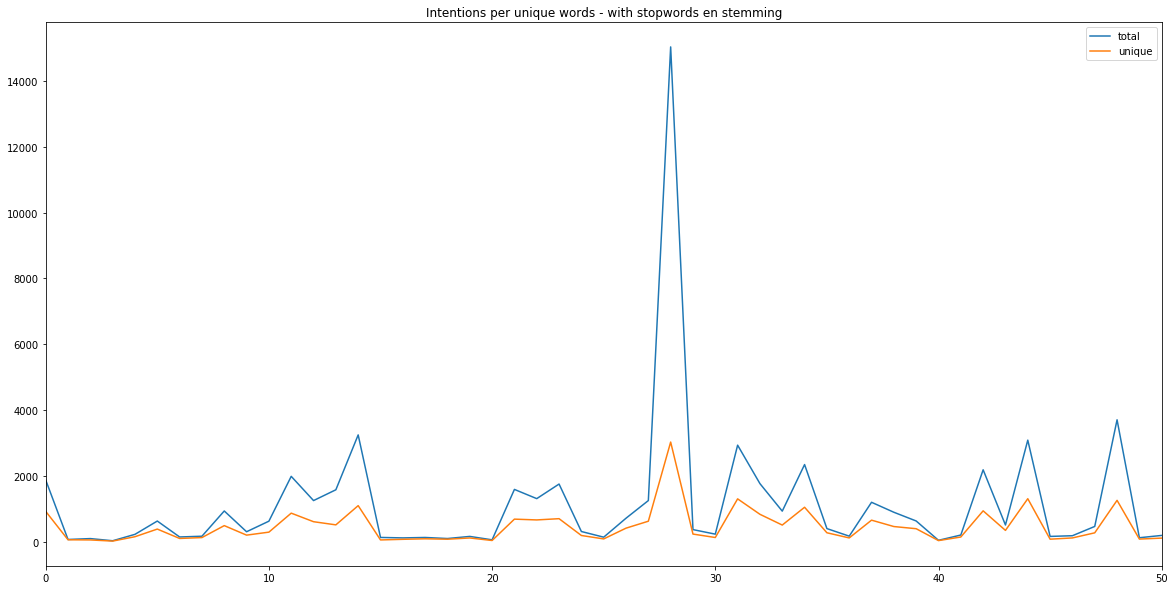

In [10]:
# Exploring stemming though we might loose some diversity
from nltk.stem.snowball import FrenchStemmer
stemmer = FrenchStemmer()

def freq_stats_corpora3(lookup_table=[]):
    corpora = defaultdict(list)
    for question,intention in zip(input_train['question'],output_train['intention']):
        tokens = tokenizer.tokenize(question.lower())
        corpora[intention] += [stemmer.stem(w) for w in tokens if not w in list(sw)]

    stats, freq = dict(), dict()
    for k, v in corpora.items():
        freq[k] = fq = nltk.FreqDist(v)
        stats[k] = {'total': len(v), 'unique': len(fq.keys())}   
    return (freq, stats, corpora)

freq3, stats3, corpora3 = freq_stats_corpora3()
df = pd.DataFrame.from_dict(stats3, orient='index')
df.plot(title='Intentions per unique words - with stopwords en stemming')

In [11]:
# Random split 
from sklearn.model_selection import train_test_split
X = input_train['question']
y = output_train['intention']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [12]:
# Classic TF-IDF with the computed stopword, not using stemming
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
count_vect = CountVectorizer(stop_words=sw)
X_train_counts = count_vect.fit_transform((X_train))
transformer = TfidfTransformer()
tfidf_vector_train = transformer.fit_transform(X_train_counts)

In [13]:
# NB should be little better than a SVM on an umballanced dataset
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
clf = MultinomialNB().fit(tfidf_vector_train, y_train)

pipeline = Pipeline([('vect', CountVectorizer(ngram_range=(1,2))), ('tfidf', TfidfTransformer()), ('clf', MultinomialNB(alpha=0.01, class_prior = None, fit_prior = True))])

text_clf = pipeline.fit(X_train, y_train)

y_pred = text_clf.predict(X_val)

In [14]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
def score(y_pred, y_test):
    print('F1_macro    : ',f1_score(y_test, y_pred, average='macro'))
    print('F1_micro    : ',f1_score(y_test, y_pred, average='micro'))
    print('F1_weighted : ',f1_score(y_test, y_pred, average='weighted'))
    
score(y_pred,y_val)

F1_macro    :  0.4453049210748941
F1_micro    :  0.6019095060190951
F1_weighted :  0.5820319256975779


/opt/anaconda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization


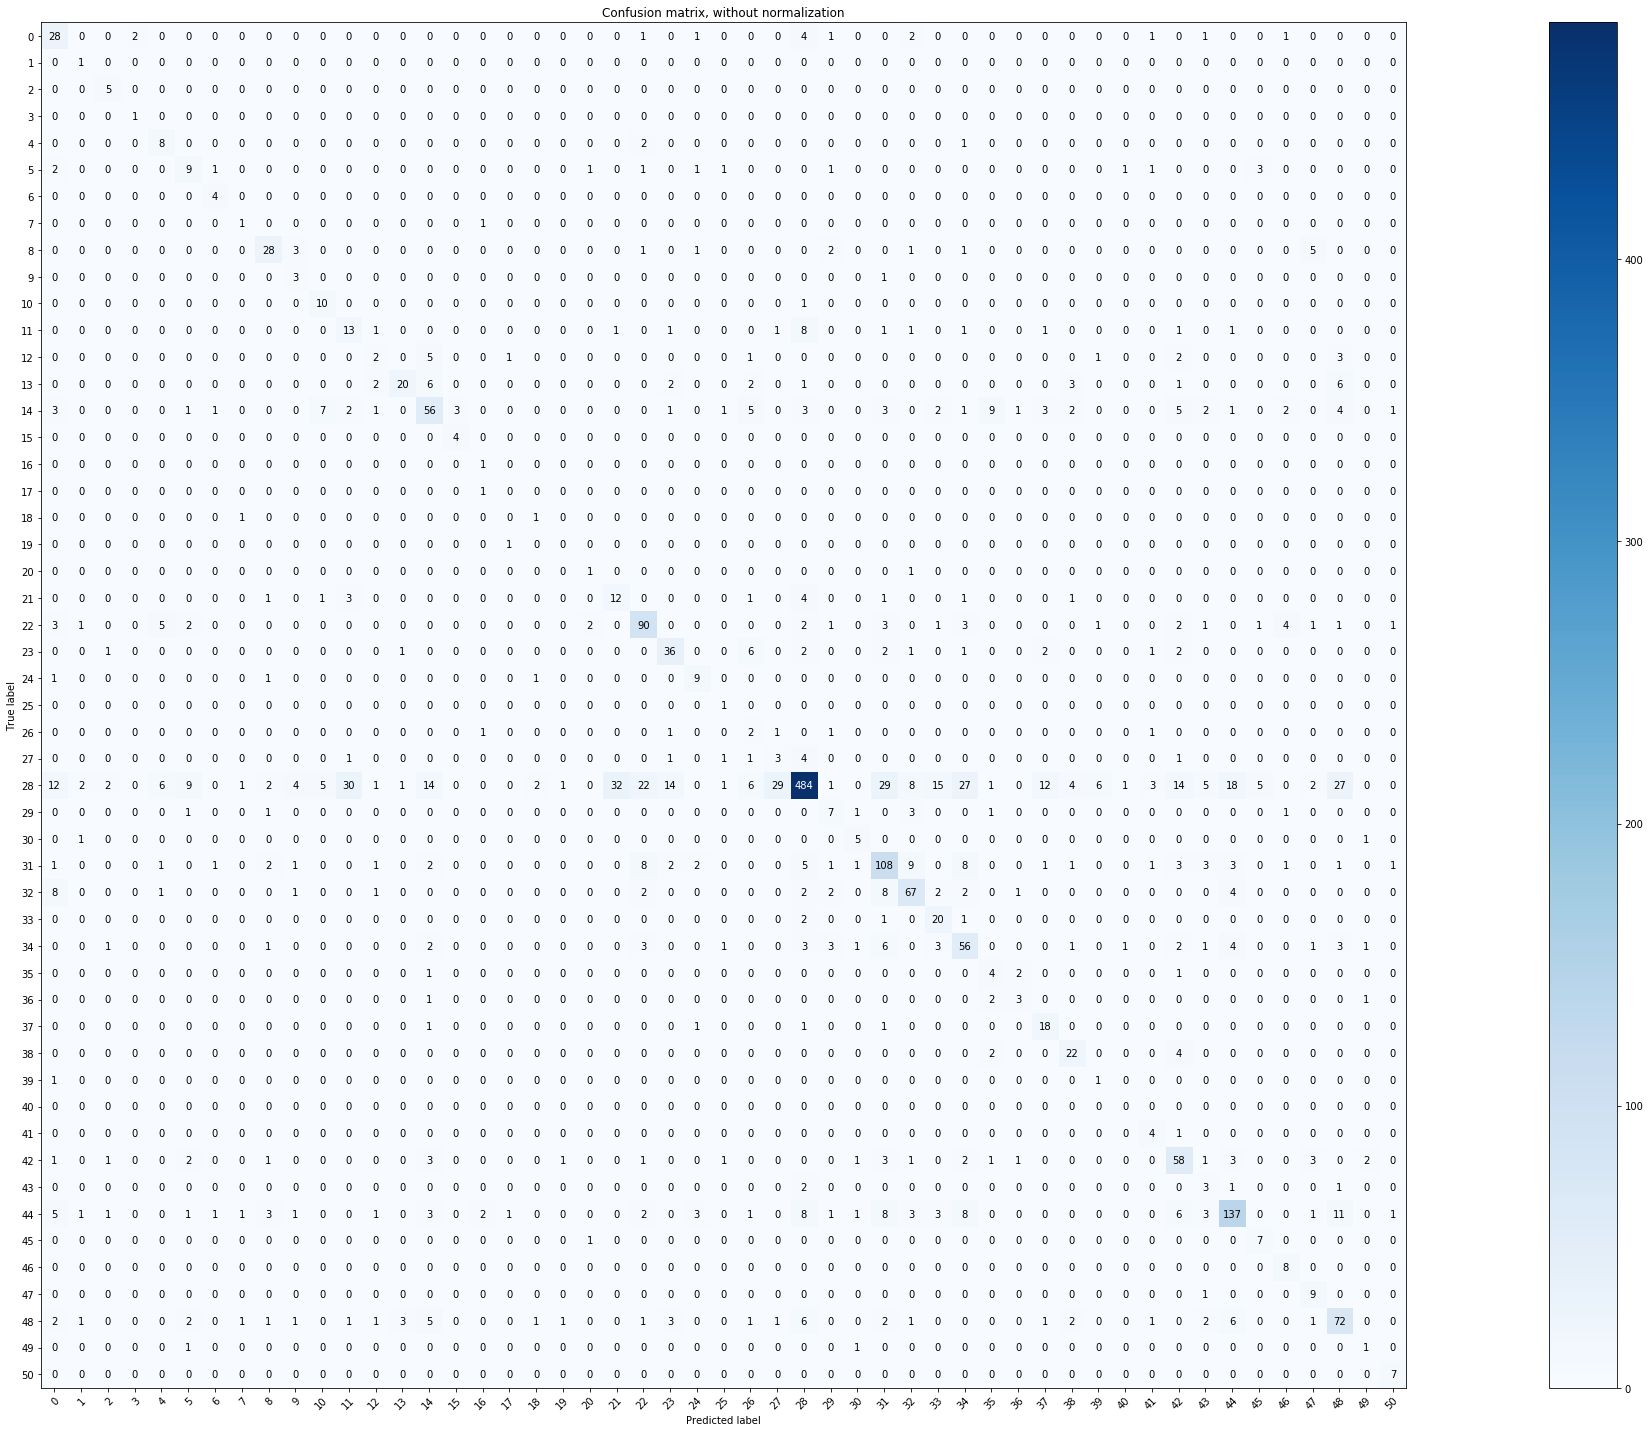

In [15]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

plt.rcParams["figure.figsize"] = (40,20)
plot_confusion_matrix(y_pred, y_val, [str(x) for x in range(51)],normalize=False)

In [16]:
# As there is 542 prediction of label "28" in the validation set, this overrepresented class causes overfitting.

In [17]:
# Let's explore under and over sampling
X = input_train['question'] # Reloading
y = output_train['intention']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.30, random_state=42)

In [18]:
result = pd.concat([X_train, y_train], axis=1, sort=False)
g = result.groupby('intention', group_keys=False)
balanced_df = pd.DataFrame(g.apply(lambda x: x.sample(1500,replace=True))) # We resample with replacement so every class has 1500 samples
X_train = pd.Series(balanced_df['question'])
y_train = pd.Series(balanced_df['intention'])

In [19]:
text_clf = pipeline.fit(X_train, y_train)
y_pred = text_clf.predict(X_val)
score(y_pred,y_val)

F1_macro    :  0.45275638108241606
F1_micro    :  0.5745122457451225
F1_weighted :  0.571124930629051


In [ ]:
plot_confusion_matrix(y_pred, y_val, [str(x) for x in range(51)],normalize=False)

Confusion matrix, without normalization


In [ ]:
# The results are a bit worse. It would be better to use under and over sampling indepedently. Especially oversampling using SMOTE from imblearn.